# LISST-200x on rosette - data processing notebook

**Disclaimer: this code is under development and can still contain multiple errors.**

The following notebook was developed by the Suspended Material and Seabed Monitoring and Modelling (SUMO) group from the Institute of Natural Sciences, Belgium. It aims at providing a standard protocol to process data collected *in-situ* with a LISST-200x instrument placed on a rosette profiling the water column. To use this notebook, simply import the data previously converted to csv by the LISST-200x software, run the cells containing code and inspect the results obtained. The graphs can then be saved as jpg and the processed data as csv.

In this notebook, the LISST-200x data processing has been divided into three stages:
1. *CSV data generation*: The first stage, during which the raw data is converted from .rbn to .csv, requires the use of the LISST-200x software. 
2. *Data import & flagging*: This notebook can then be used to carry out the second stage, which includes the import and pre-processing of the data (i.e. date conversion, data flagging). At the end of this stage, the user can save the full dataset with a flagging system and dates as datetime. 
3. *Statistics computation & visualization*: The third stage performs the calculation of different statistical parameters on the clean dataset (after filtrating data above a certain flag value), such as mean particle diameter, D10, D50, D90 and distribution characteristics, and displays outputs as graphs. The clean dataset as well as the graphs can be saved. 

**Important!** Before starting the processing, make sure that all the necessary packages and libraries are installed on your computer and that you run the cell below to import everything that is required. Before running this cell, make sure you've installed all the necessary packages on your computer. To do that, you can run the following line in the prompt (we highly recommend to create a new environment to do so):
- pip install tk pandas numpy matplotlib seaborn scipy

In [1]:
                                                    ## Cell 01 ##
import os
import ipywidgets as widgets
from IPython.display import display
import shutil
import tkinter as tk
from tkinter import filedialog, messagebox
from tkinter.filedialog import asksaveasfilename
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.signal import find_peaks, savgol_filter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
                                                        ###

## Stage 1: Conversion of rbn files to csv files

In this stage, the conversion of the raw LISST-200x data is performed using the LISST-200x software, which can be downloaded freely on https://www.sequoiasci.com/product/lisst-200x/. Always make sure to double-check if the background is acceptable before processing the data.

## Stage 2: Data pre-processing

#### Stage 2 - Step 1 : Enter metadata

In this cell, the user will be asked to enter the campaign identification code, year at which the data were collected, the name of the sampling location and coordinates in decimal degrees (XX.XXXXX). Press enter after each input.
**Important!** Avoid using "/" in the campaign identification code, as it might create issues when saving the data.

In [4]:
                                                    ## Cell 02 ##
campaign_code = input("Enter the campaign identification code: ")
location = input("Enter the name of the sampling location: ")
latitude = input("Enter the latitude of the data: ")
longitude = input("Enter the longitude of the data: ")
                                                        ###

#### Stage 2 - Step 2 : Data import & formatting

Upon running this cell, a new window should automatically open and invite the user to select the csv file to be processed. **!This window might open in the background and could be hidden under the current window.** Once imported, the data will be attributed column names, campaign identification number and sampling location (as inserted by the user in the cell above). In addition to that, year, day, hour, minute and second columns will be converted to jday and datetime values. A new column containing a flag value (set by default to zero at this step) will be added at the end of the dataset. 

The dataset will be displayed upon running the cell, enabling the user to check that columns and values were assigned correctly and that the calculated date and time of the data correspond to the actual sampling time.

In [5]:
                                                    ## Cell 03 ##
# Open a window to select input file
root = tk.Tk()
root.withdraw()
file_path = filedialog.askopenfilename(title="Select a CSV file", filetypes=[("CSV files", "*.csv")])
directory_path = os.path.dirname(file_path)

output_directory = f"{directory_path}/LISST-200x-{campaign_code}-{location}-processed"
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)
    print(f'Existing output folder removed at: {output_directory}')
os.makedirs(output_directory)
print(f'Output folder created at: {output_directory}')

if file_path:  
    try:
        data = pd.read_csv(file_path, header=None, sep=",")
        print("File successfully loaded!") 
        # Add column names
        data.columns = ["1.21","1.6","1.89","2.23","2.63","3.11","3.67","4.33","5.11","6.03","7.11","8.39","9.90","11.7","13.8","16.3","19.2","22.7","26.7","31.6","37.2","43.9","51.9","61.2","72.2","85.2","101","119","140","165","195","230","273","324","386","459","laser_transmission_sensor_mW","supply_voltage_V","external_input_1_V","laser_reference_sensor_mW","depth_in_m","temperature_C","year","month","day","hour","minute","second","external_input_2_V","mean_diameter_um","total_volume_concentration_ppm","relative_humidity_%","accelerometer_x","accelerometer_y","accelerometer_z","raw_pressure_most_significant","raw_pressure_least_significant","ambient_light_counts","external_analog_input_3_V","computed_optical_transmission","beam_attenuation_m"]
        # Add campaign identification number, sampling location name, latitude and longitude
        data['campaign'] = campaign_code
        data['location'] = location
        data['latitude'] = latitude
        data['longitude'] = longitude
        for col in data.columns.difference(['campaign', 'location']):
            if pd.api.types.is_numeric_dtype(data[col]) or data[col].dtype == object:
                data[col] = data[col].astype(str).str.replace(r"[^\d.-]", "", regex=True)  # Retain numbers, decimal points, and negatives
                data[col] = pd.to_numeric(data[col], errors='coerce')  # Convert to numeric, invalid entries to NaN
        # Calculate julian day & datetime
        data['year'] = data['year'].astype(str).str.zfill(2)
        data['month'] = data['month'].astype(str).str.zfill(2)
        data['day'] = data['day'].astype(str).str.zfill(2)
        data['hour'] = data['hour'].astype(str).str.zfill(2)
        data['minute'] = data['minute'].astype(str).str.zfill(2)
        data['second'] = data['second'].astype(str).str.zfill(2)
        data['datetime'] = data['year'].astype(str) +"-"+ data['month'].astype(str) +"-"+ data['day'].astype(str)+" "+data['hour'].astype(str) +":"+ data['minute'].astype(str) +":"+ data['second'].astype(str)
        data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')
        data['jday'] = data['datetime'].dt.dayofyear + \
               (data['datetime'].dt.hour / 24) + \
               (data['datetime'].dt.minute / 1440) + \
               (data['datetime'].dt.second / 86400)
        data['flag'] = 0
        # Compute sampling start and stop datetime
        sampling_start = data['datetime'].min()
        sampling_stop = data['datetime'].max()
        # Display output
        print(f'Data were collected at {location} between {sampling_start} and {sampling_stop} during deployment {campaign_code}.')
        display(data)
    except Exception as e:
        print(f"Error reading the file: {e}")
else:
    print("No file selected")
                                                        ###

Output folder created at: C:/Users/ldelhaye/OneDrive - Royal Belgian Institute of Natural Sciences/Documents/02_Data/Codevco/LISST-200x/Rosette_COD_ST2308_LISST200x/LISST-200x-ST202308-Eastern_transect-processed
File successfully loaded!
Data were collected at Eastern_transect between 2023-04-23 01:54:18 and 2023-04-23 08:27:37 during deployment ST202308.


,1.21,1.6,1.89,2.23,2.63,3.11,3.67,4.33,5.11,6.03,...,external_analog_input_3_V,computed_optical_transmission,beam_attenuation_m,campaign,location,latitude,longitude,datetime,jday,flag
0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.139,0.502,27.559,ST202308,Eastern_transect,NaN,NaN,2023-04-23 01:54:18,113.079375,0
1,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.139,0.514,26.652,ST202308,Eastern_transect,NaN,NaN,2023-04-23 01:54:19,113.079387,0
2,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.139,0.501,27.622,ST202308,Eastern_transect,NaN,NaN,2023-04-23 01:54:20,113.079398,0
3,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.139,0.503,27.524,ST202308,Eastern_transect,NaN,NaN,2023-04-23 01:54:21,113.079410,0
4,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.139,0.510,26.930,ST202308,Eastern_transect,NaN,NaN,2023-04-23 01:54:22,113.079421,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23594,0.0,0.0,0.0,0.0,0.0,0.1201,2.8104,11.5412,12.4684,1.8533,...,0.139,0.177,69.300,ST202308,Eastern_transect,NaN,NaN,2023-04-23 08:27:33,113.352465,0
23595,0.0,0.0,0.0,0.0,0.0,0.0000,0.1393,6.8136,23.6046,9.1906,...,0.140,0.173,70.175,ST202308,Eastern_transect,NaN,NaN,2023-04-23 08:27:34,113.352477,0
23596,0.0,0.0,0.0,0.0,0.0,0.0037,0.3614,9.3182,23.2109,6.4050,...,0.140,0.175,69.795,ST202308,Eastern_transect,NaN,NaN,2023-04-23 08:27:35,113.352488,0
23597,0.0,0.0,0.0,0.0,0.0,0.0269,0.9951,8.6684,15.6791,4.2646,...,0.139,0.178,68.955,ST202308,Eastern_transect,NaN,NaN,2023-04-23 08:27:36,113.352500,0


#### Stage 2 - Step 3: Flagging of the data

In this cell, flagging operations are performed as follows:
1. A first check is done on the **reference laser**, if values are below 0.2 mW, this indicates that the laser is likely not working properly. Quality flags will be assigned to 1 if data are above this value and to 3 if not (see flags meaning below). If more than 10% of the data present such a low value, a warning message will be displayed.  
2. Data out of the water are flagged with the value of 4 (rows where the beam attenuation is equal to zero). The **beam attenuation** corresponds to the loss of light intensity when a laser beam passes through water, due to both absorption and scattering. Higher attenuation values typically indicate more turbid water. 
3. The **laser transmission** values are checked. This indicates how much of the laser light has passed through water without being absorbed or scattered. A value of 100% indicates that there has been no light loss through the sample (either water without particles or air) while values below indicate scattering and absorption (which is expected in seawater). Values above 100%, however, indicate a sensor malfunction or miscalibration. If most data (>50%) are above 100%, then a warning message is generated. Data above 100 are flagged with the value of 3. 
4. The **optical transmission** is checked: values should be ranging between 0 and 1. Values outside that range should be discarded (flag 4). However, values above 0.98-0.995 reflect extremely clear water conditions, meaning a low signal-to-noise ratio (flag 3, to be taken with caution. Above that range, values should be discarded), whereas values below 0.10 reflect very turbid data and should be discarded. 
5. Finally, a flag of 3 is attributed to **outliers** detected based on the total volume concentration, depth, optical beam transmission and temperature and comparing the value of each point to the calculated mean over a moving window of 25 points. Values are considered outliers when they are higher or lower than the moving average plus or minus three times the standard deviation.

Once the flagging has been performed, a graph allows the user to visualize the quality of the data. The complete flagged dataset is automatically saved in the output directory selected by the user at the beginning of this notebook. In stage 3, a cell then allows to filter out all the data with a quality flag equal or higher than 4.

Quality flags are defined following the quality flags standards defined by the NERC Environmental Data Service of the British Oceanographic Data Centre (https://vocab.nerc.ac.uk/collection/L20/current/):
0: No quality control
1: Good value
2: Probably good value
3: Probably bad value
4: Bad value
5: Changed value
6: Value below detection
7: Value in excess
8: Interpolated value
9: Missing value

Number of outliers detected: 286
Flagging has been successfully performed on the complete dataset:


,1.21,1.6,1.89,2.23,2.63,3.11,3.67,4.33,5.11,6.03,...,latitude,longitude,datetime,jday,flag,is_outlier_total_volume_concentration_ppm,is_outlier_temperature_C,is_outlier_depth_in_m,is_outlier_computed_optical_transmission,is_outlier
0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,...,NaN,NaN,2023-04-23 01:54:18,113.079375,1,False,False,False,False,False
1,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,...,NaN,NaN,2023-04-23 01:54:19,113.079387,1,False,False,False,False,False
2,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,...,NaN,NaN,2023-04-23 01:54:20,113.079398,1,False,False,False,False,False
3,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,...,NaN,NaN,2023-04-23 01:54:21,113.079410,1,False,False,False,False,False
4,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,...,NaN,NaN,2023-04-23 01:54:22,113.079421,1,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23594,0.0,0.0,0.0,0.0,0.0,0.1201,2.8104,11.5412,12.4684,1.8533,...,NaN,NaN,2023-04-23 08:27:33,113.352465,1,False,False,False,False,False
23595,0.0,0.0,0.0,0.0,0.0,0.0000,0.1393,6.8136,23.6046,9.1906,...,NaN,NaN,2023-04-23 08:27:34,113.352477,1,False,False,False,False,False
23596,0.0,0.0,0.0,0.0,0.0,0.0037,0.3614,9.3182,23.2109,6.4050,...,NaN,NaN,2023-04-23 08:27:35,113.352488,1,False,False,False,False,False
23597,0.0,0.0,0.0,0.0,0.0,0.0269,0.9951,8.6684,15.6791,4.2646,...,NaN,NaN,2023-04-23 08:27:36,113.352500,1,False,False,False,False,False


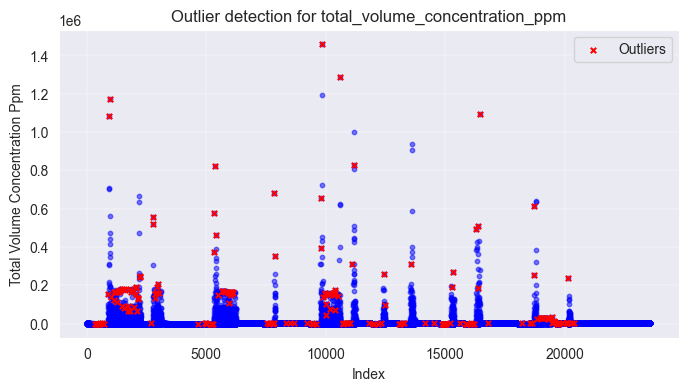

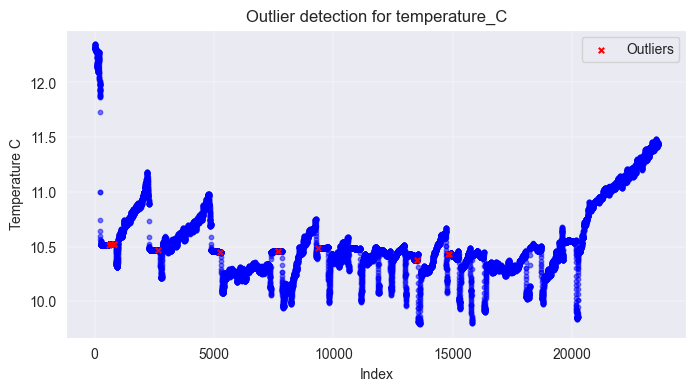

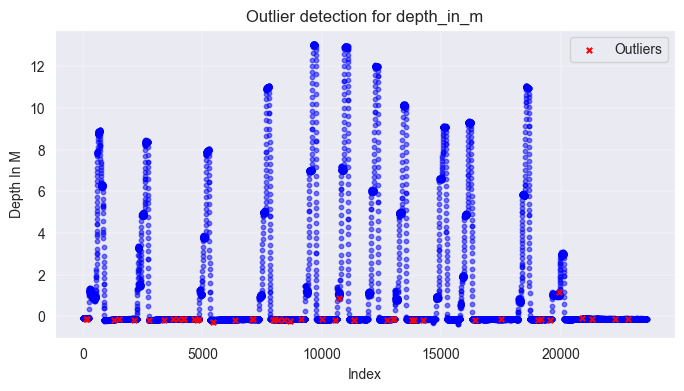

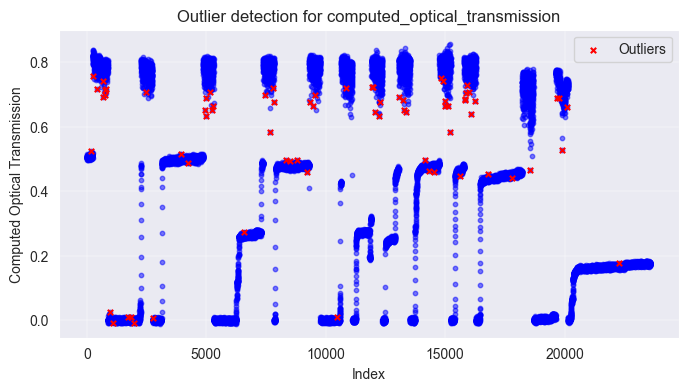

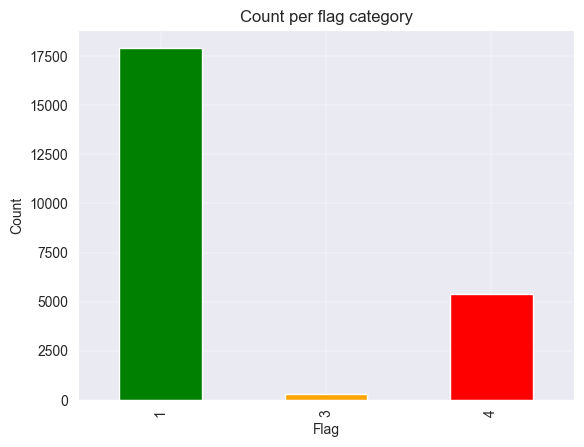

NameError: name 'deployment_code' is not defined

In [6]:
                                                    ## Cell 04 ##
# Step 1: Flagging based on reference_laser
data['flag'] = data.apply(lambda row: max(row['flag'], 1) if row['laser_reference_sensor_mW'] > 0.02 else max(row['flag'], 3), axis=1)
reference_below_thsld = (data['laser_reference_sensor_mW'] <= 0.02).sum() / len(data) * 100
if reference_below_thsld > 20:  # If more than 20% of the data are below 0.02 mW
    messagebox.showwarning("Laser should be checked", 
                           f"Warning: {reference_below_thsld:.0f}% of the data have a laser reference value below 0.02 mW. "
                           "Please check laser.")

# Step 2: Beam attenuation flagging
data['flag'] = data.apply(lambda row: max(row['flag'], 4) if row['beam_attenuation_m'] <= 0 else row['flag'], axis=1)

# Step 3: Laser transmission flagging
data['flag'] = data.apply(lambda row: 3 if row['laser_transmission_sensor_mW'] > 100 and row['flag'] < 3 else row['flag'], axis=1)
underwater_data = data[data['beam_attenuation_m'] > 0]
above_100_percent = (underwater_data['laser_transmission_sensor_mW'] > 100).sum() / len(underwater_data) * 100
above_100_percent = (data['laser_transmission_sensor_mW'] > 100).sum() / len(data) * 100
if above_100_percent > 50:  # If more than 50% of the data are above 100%
    messagebox.showwarning("Recalibration Needed", 
                           f"Warning: {above_100_percent:.0f}% of the underwater data are above 100% transmission. "
                           "Please recalibrate the sensor.")
    
# Step 4: Optical transmission flagging
data['flag'] = data.apply(lambda row: 3 if row['computed_optical_transmission'] > 0.98 and row['computed_optical_transmission'] < 0.995 and row['flag'] < 3 else row['flag'], axis=1)
data['flag'] = data.apply(lambda row: 4 if row['computed_optical_transmission'] >= 0.995 and row['flag'] < 4 else row['flag'], axis=1)
data['flag'] = data.apply(lambda row: 4 if row['computed_optical_transmission'] <= 0.10 and row['flag'] < 4 else row['flag'], axis=1)
    
# Step 5: Outlier detection using rolling mean and standard deviation
columns_to_check = ['total_volume_concentration_ppm', 'temperature_C', 'depth_in_m', 'computed_optical_transmission']
window_size = 25  # Define the window size for rolling calculations
threshold = 3  # Define the threshold for outlier detection

for col in columns_to_check:
    rolling_mean = data[col].rolling(window=window_size, center=True).mean()
    rolling_std = data[col].rolling(window=window_size, center=True).std()
    outlier_column = f'is_outlier_{col}'  # Create a column to flag outliers for each variable
    data[outlier_column] = abs(data[col] - rolling_mean) > (threshold * rolling_std)

    # Update the 'flag' column if the data is an outlier
    data['flag'] = data.apply(
        lambda row: 3 if row[outlier_column] else row['flag'], axis=1
    )

# Combine all outlier flags into one column for visualization
data['is_outlier'] = data[[f'is_outlier_{col}' for col in columns_to_check]].any(axis=1)

# Count total outliers
outlier_count = data['is_outlier'].sum()
print(f'Number of outliers detected: {outlier_count}')

# Warning message if quality flags exceed 75%
percentage_high_flags = (data['flag'] >= 3).sum() / len(data) * 100
if percentage_high_flags > 75:  # If more than 75% of the data have a quality flag of 3 or higher
    messagebox.showwarning("Unsatisfactory data quality", 
                           f"Warning: {percentage_high_flags:.0f}% of the data have a quality flag above 3. "
                           "Data should be used with caution.")

# Output
print('Flagging has been successfully performed on the complete dataset:')
display(data)

# Visualizing outliers for each column
for col in columns_to_check:
    plt.figure(figsize=(8, 4))
    plt.scatter(data.index, data[col], label='', color='blue', s=10, alpha=0.5)
    plt.scatter(
        data[data[f'is_outlier_{col}']].index, 
        data[data[f'is_outlier_{col}']][col], 
        label='Outliers', color='red', marker='x', s=15
    )
    plt.grid(axis='both', which='both', linewidth=0.3)
    plt.title(f'Outlier detection for {col}')
    plt.xlabel('Index')
    plt.ylabel(col.replace('_', ' ').title())
    plt.legend()
    plt.show()

# Visualizing flags
flag_counts = data['flag'].value_counts().sort_index()
colors = {1: 'green', 2: 'yellow', 3: 'orange', 4: 'red'}
fig, ax = plt.subplots()
flag_counts.plot(kind='bar', color=[colors.get(flag, 'blue') for flag in flag_counts.index], ax=ax)
ax.grid(axis='both', which='both', linewidth=0.3)
ax.set_title("Count per flag category")
ax.set_xlabel("Flag")
ax.set_ylabel("Count")
plt.show()

# Save as csv
data_path = f"{output_directory}/{deployment_code}-{location}-LISST200x-full-data.csv"
if data_path:
    data.to_csv(data_path, index=False)
    print(f"File saved to {file_path}")
else:
    print("Save operation cancelled.")
                                                        ###

## Stage 3: Statistics computation & visualization

#### Stage 3 - Step 1: Statistics computation

By running this cell, a series of statistics are calculated on the full dataset. This includes:
1. **Total volume concentration**: This sums up the volume concentration of each grain size class per row.
2. **Relative volume concentration**: This calculates the percentage that each class represents compared to the total volume concentration.
3. **Mean diameter**: This corresponds to the mean diameter of particles in each row weighted by their volume concentration and normalized by the total volume concentration.
4. **D10, D50, D90 values**: These represent the diameter below which 10%, 50% or 90% of the volume of the data are found. The D10 helps characterizing the finer fraction of the sample, the D50 corresponds to the median diameter and the D90 characterizes the coarser sediment fraction. These values are calculated based on the cumulative distribution.
5. **Span**: It is a measure of the sorting of particle sizes, as a normalized measure of the distribution spread around the median particle size, showing the relative range of the middle 80% of the particle size distribution. Small values indicate good sorting (close to 1) while a larger span indicates poor sorting of the particles.
6. **Standard deviation**: It measures the average dispersion of particle sizes from the mean, a greater standard deviation shows greater variability around the mean with possible outliers or tails. If the span and standard deviation are low, it shows a uniform distribution; if the span is moderate but the standard deviation is high, it shows a moderate spread with outliers; and if the span and standard deviation are high, it shows a wide distribution.
7. **Mode**: The mode is the particle size that has the largest volume of the distribution (peak in the distribution).
8. **Peaks in the distribution**: It identifies peaks in the particle size distribution.

The particle size distribution combined with the cumulative volume concentration is displayed upon running of this cell as well as a table with the mean value of all the calculated parameters. The graph and updated complete clean dataframe are automatically saved in the directory selected by the user.

In [ ]:
                                                    ## Cell 05 ##  
# Calculate the total volume concentration 
volume_concentration_columns = ["1.21","1.6","1.89","2.23","2.63","3.11","3.67","4.33","5.11","6.03","7.11","8.39","9.90","11.7","13.8","16.3","19.2","22.7","26.7","31.6","37.2","43.9","51.9","61.2","72.2","85.2","101","119","140","165","195","230","273","324","386","459"]
average_volume_fractions = data[volume_concentration_columns].mean()
volume_concentrations = data[volume_concentration_columns].values
grain_sizes = np.array([float(col) for col in volume_concentration_columns])

# Calculate the percentage of each class compared to the total volume concentration
for col in volume_concentration_columns:
    data[f'{col}_%'] = ((data[col] / data['total_volume_concentration_ppm']) * 100).astype(float)

# Cumulative volume concentration
cumulative_volumes = np.cumsum(data[volume_concentration_columns].values, axis=1)

# Percentiles calculation function
def calculate_d_percentile(cumulative_volumes, grain_sizes, total_volume, percentile):
    target = total_volume * (percentile / 100.0)
    d_percentile = []
    for i in range(len(total_volume)):
        if total_volume.iloc[i] == 0: 
            d_percentile.append(np.nan)
        else:
            greater_equal_idx = np.argmax(cumulative_volumes[i, :] >= target.iloc[i])
            d_percentile.append(grain_sizes[greater_equal_idx])
    return np.array(d_percentile)

# Calculate D10, D50, D90
data['D10_um'] = calculate_d_percentile(cumulative_volumes, grain_sizes, data['total_volume_concentration_ppm'], 10)
data['D50_um'] = calculate_d_percentile(cumulative_volumes, grain_sizes, data['total_volume_concentration_ppm'], 50)
data['D90_um'] = calculate_d_percentile(cumulative_volumes, grain_sizes, data['total_volume_concentration_ppm'], 90)

# Calculate the span
data['span'] = (data['D90_um'] - data['D10_um']) / data['D50_um']

# Calculate the standard deviation
def calculate_std(grain_sizes, volume_concentrations, mean_diameter):
    variance = np.sum(volume_concentrations * (grain_sizes - mean_diameter[:, None])**2, axis=1) / np.sum(volume_concentrations, axis=1)
    return np.sqrt(variance)
data['std_dev_um'] = calculate_std(grain_sizes, volume_concentrations, data['mean_diameter_um'].values)

# Calculate the mode
def calculate_mode(grain_sizes, volume_concentrations):
    mode_values = []
    for vc in volume_concentrations:
        if np.all(vc == 0):
            mode_values.append(np.nan)
        else:
            mode_index = np.argmax(vc)
            mode_values.append(grain_sizes[mode_index])
    return np.array(mode_values)
data['mode_um'] = calculate_mode(grain_sizes, volume_concentrations)

# Identify peaks in the distribution 
def find_all_peaks(grain_sizes, volume_concentrations):
    all_peaks = []
    for vc in volume_concentrations:
        if np.all(vc == 0):
            all_peaks.append([])
        else:
            peaks, _ = find_peaks(vc)
            peak_sizes = grain_sizes[peaks]
            all_peaks.append(peak_sizes.tolist())
    return all_peaks
data['peaks'] = find_all_peaks(grain_sizes, volume_concentrations)

# Display updated dataframe
print('Statistics have been successfully computed')
display(data)

# Display the histogram of the particle size distribution and the cumulative volume distribution (in red)
total_volume_concentration_per_class = data[volume_concentration_columns].sum(axis=0)
fig, ax1 = plt.subplots(figsize=(10, 6), dpi=300)
ax1.plot(grain_sizes, total_volume_concentration_per_class, color='blue', marker='o', 
         label='Particle size distribution', linestyle='-')
ax1.set_xscale('log')
ax1.set_xlabel('Grain size (µm)')
ax1.set_ylabel('Total volume concentration (µl/l)')
ax1.set_title(f'LISST-200x {location} {deployment_code}')
ax1.grid(axis='both', which='both', linewidth=0.3)
cumulative_volumes = np.cumsum(total_volume_concentration_per_class)
ax2 = ax1.twinx() 
ax2.plot(grain_sizes, cumulative_volumes / cumulative_volumes[-1] * 100, color='red', 
         label='Cumulative Distribution', marker='o')
ax2.set_ylabel('Cumulative volume (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax1.axvline(data['D10_um'].mean(), color='green', linestyle='--', label='D10')
ax1.axvline(data['D50_um'].mean(), color='orange', linestyle='--', label='D50')
ax1.axvline(data['D90_um'].mean(), color='purple', linestyle='--', label='D90')
ax1.legend(loc='upper left')
ax2.legend(loc='upper center')
plt.tight_layout()
plt.show()
graph_file_path = f"{output_directory}/{deployment_code}-{location}-LISST200x-full-PSD.png"
fig.savefig(graph_file_path) 

# Display table with the mean of each parameter
mean_values = {
    'Total volume concentration (ppm)': data['total_volume_concentration_ppm'].mean(),
    'Mean diameter (µm)': data['mean_diameter_um'].mean(),
    'D10 (µm)': data['D10_um'].mean(),
    'D50 (µm)': data['D50_um'].mean(),
    'D90 (µm)': data['D90_um'].mean(),
    'Span': data['span'].mean(),
    'Standard deviation (µm)': data['std_dev_um'].mean(),
    'Mode (µm)': data['mode_um'].mean()
}
mean_values_df = pd.DataFrame(mean_values, index=[0])
print('Mean values of calculated parameters for the complete clean dataset:')
display(mean_values_df)

fig, axs = plt.subplots(5, 1, figsize=(10, 12), dpi=300, sharex=True)
axs[0].set_title(f'LISST-200x {location} {deployment_code}')
axs[0].plot(data['datetime'], data['depth_in_m'], color='steelblue', linestyle='-', linewidth=0.4)
axs[0].set_ylabel('Depth (m)')
axs[0].grid(axis='both', which='both', linewidth=0.3)
axs[1].plot(data['datetime'], data['computed_optical_transmission'], color='steelblue', linestyle='-', linewidth=0.4)
axs[1].set_ylabel('Optical transmission (%)')
axs[1].grid(axis='both', which='both', linewidth=0.3)
axs[2].plot(data['datetime'], data['temperature_C'], color='steelblue', linestyle='-', linewidth=0.4)
axs[2].set_ylabel('Temperature (°C)')
axs[2].grid(axis='both', which='both', linewidth=0.3)
axs[3].plot(data['datetime'], data['total_volume_concentration_ppm'], color='steelblue', linestyle='-', linewidth=0.4)
axs[3].set_ylabel('Total volume concentration (ppm)')
axs[3].grid(axis='both', which='both', linewidth=0.3)
axs[4].plot(data['datetime'], data['mean_diameter_um'], color='steelblue', linestyle='-', linewidth=0.4)
axs[4].set_ylabel('Mean diameter (µm)')
axs[4].grid(axis='both', which='both', linewidth=0.3)
axs[4].set_xlabel('')
#axs[4].xaxis.set_major_formatter(mdates.DateFormatter('%D'))
axs[4].xaxis.set_major_locator(mdates.DayLocator(interval=7))
fig.align_ylabels()
plt.tight_layout()
plt.show()
graph_file_path = f"{output_directory}/{deployment_code}-{location}-LISST200x-g-full-graph2.png"
fig.savefig(graph_file_path) 

# Save output
print(f'Graphs are saved to: {output_directory}')
                                                        ###

#### Stage 3 - Step 2: Manual adjustment of acceptable optical transmission, total volume concentration and/or mean diameter values (optional, upon verification on the graph above)

The following cell is optional and does not have to be ran if no additional filtering of the data is needed. This decision should be done following a visual inspection of the graph generated in cell 5 above. The user can define minimum and/or maximum thresholds for five possible fields (optical transmission, total volume concentration, mean diameter, pressure and/or temperature) below and/or above which the data are flagged to 4. The full dataset is saved again.
If one threshold wants to be ignored, it can be set to -99.99.

In [ ]:
                                                    ## Cell 06 ##
# Initialize thresholds
minimum_threshold = -99.99
maximum_threshold = -99.99

# Dropdown for field selection
field_threshold_dropdown = widgets.Dropdown(
    options=['optical transmission', 'total volume concentration', 'mean diameter', 'depth', 'temperature'],
    value=None,
    description='Select field on which to apply a threshold:',
    style={'description_width': 'initial'}
)

# Widgets for threshold inputs (initially hidden)
min_threshold_widget = widgets.FloatText(
    value=-99.99,
    description='Minimum threshold:',
    style={'description_width': 'initial'}
)
max_threshold_widget = widgets.FloatText(
    value=-99.99,
    description='Maximum threshold:',
    style={'description_width': 'initial'}
)

# Button to apply thresholds (initially hidden)
apply_button = widgets.Button(
    description='Apply Thresholds',
    button_style='success'
)

# Container to display widgets dynamically
threshold_widgets_container = widgets.VBox([])

# Function to handle dropdown changes
def on_field_change(change):
    selected_field = change['new']
    if selected_field:
        print(f"Selected field: {selected_field}")
        # Display threshold widgets and apply button
        threshold_widgets_container.children = [min_threshold_widget, max_threshold_widget, apply_button]
    else:
        # Hide threshold widgets and apply button
        threshold_widgets_container.children = []

# Observe dropdown changes
field_threshold_dropdown.observe(on_field_change, names='value')

# Function to apply thresholds
def apply_thresholds(_):
    global minimum_threshold, maximum_threshold
    minimum_threshold = min_threshold_widget.value
    maximum_threshold = max_threshold_widget.value
    print(f"Applying thresholds: Min = {minimum_threshold}, Max = {maximum_threshold}, Field = {field_threshold_dropdown.value}")
    
    # Apply flags based on selected field
    if field_threshold_dropdown.value == 'optical transmission':
        if minimum_threshold != -99.99:
            data['flag'] = data.apply(
                lambda row: 4 if row['computed_optical_transmission'] < minimum_threshold and row['flag'] < 4 else row['flag'], axis=1
            )
        if maximum_threshold != -99.99:
            data['flag'] = data.apply(
                lambda row: 4 if row['computed_optical_transmission'] > maximum_threshold and row['flag'] < 4 else row['flag'], axis=1
            )
    elif field_threshold_dropdown.value == 'total volume concentration':
        if minimum_threshold != -99.99:
            data['flag'] = data.apply(
                lambda row: 4 if row['total_volume_concentration_ppm'] < minimum_threshold and row['flag'] < 4 else row['flag'], axis=1
            )
        if maximum_threshold != -99.99:
            data['flag'] = data.apply(
                lambda row: 4 if row['total_volume_concentration_ppm'] > maximum_threshold and row['flag'] < 4 else row['flag'], axis=1
            )
    elif field_threshold_dropdown.value == 'mean diameter':
        if minimum_threshold != -99.99:
            data['flag'] = data.apply(
                lambda row: 4 if row['mean_diameter_um'] < minimum_threshold and row['flag'] < 4 else row['flag'], axis=1
            )
        if maximum_threshold != -99.99:
            data['flag'] = data.apply(
                lambda row: 4 if row['mean_diameter_um'] > maximum_threshold and row['flag'] < 4 else row['flag'], axis=1
            )
    elif field_threshold_dropdown.value == 'depth':
        if minimum_threshold != -99.99:
            data['flag'] = data.apply(
                lambda row: 4 if row['depth_in_m'] < minimum_threshold and row['flag'] < 4 else row['flag'], axis=1
            )
        if maximum_threshold != -99.99:
            data['flag'] = data.apply(
                lambda row: 4 if row['depth_in_m'] > maximum_threshold and row['flag'] < 4 else row['flag'], axis=1
            )
    elif field_threshold_dropdown.value == 'temperature':
        if minimum_threshold != -99.99:
            data['flag'] = data.apply(
                lambda row: 4 if row['temperature_C'] < minimum_threshold and row['flag'] < 4 else row['flag'], axis=1
            )
        if maximum_threshold != -99.99:
            data['flag'] = data.apply(
                lambda row: 4 if row['temperature_C'] > maximum_threshold and row['flag'] < 4 else row['flag'], axis=1
            )

    # Save updated data
    data_path = f"{output_directory}/{deployment_code}-{location}-LISST200x-full-data.csv"
    data.to_csv(data_path, index=False)
    print(f"File saved to {data_path}")
    print(f"Flagging has been successfully performed and the updated dataset has been saved to: {output_directory}")

# Connect button to function
apply_button.on_click(apply_thresholds)

# Display dropdown and container
display(field_threshold_dropdown, threshold_widgets_container)
                                                        ###

#### Stage 3 - Step 3: Removal of suspicious data & creation of a 'clean' dataset

This step allows the user to choose a certain flag threshold at and above which data are discarded for further analysis. The default value is set to 4, meaning all data flagged 4 and above will be removed from the filtered dataframe. In this cell, values considered outliers can also be removed.

In [ ]:
                                                    ## Cell 07 ##
try:
    threshold = int(input("Enter the threshold for flag filtration (default is 4): ") or 4)
except ValueError:
    print("Invalid input, defaulting to threshold = 4.")
    threshold = 4

outliers = input("Remove outliers (yes or no): ")

# Apply initial filters
filtered_data = data[
    (data['total_volume_concentration_ppm'] != 0) & 
    (data['mean_diameter_um'].notna()) & 
    (data['flag'] < threshold)
]

# Additional filtering based on outliers
if outliers.lower() == 'yes':
    filtered_data = filtered_data[filtered_data['is_outlier'] != True]
elif outliers.lower() != 'no':
    print("Invalid input for outliers; no outlier filtering applied.")

# Display the filtered data
print(f"After filtering, the dataset is:")
display(filtered_data)

# Save filtered data as csv
filtered_data_path = f"{output_directory}/{deployment_code}-{location}-LISST200x-clean-data.csv"
filtered_data.to_csv(filtered_data_path, index=False)
print(f"Filtered data saved to {filtered_data_path}")

# Apply Savitzky-Golay filter
filtered_data['mean_diameter_filtered_6h'] = savgol_filter(filtered_data['mean_diameter_um'], 359, 3)
filtered_data['mean_diameter_filtered_12h'] = savgol_filter(filtered_data['mean_diameter_um'], 719, 3)
filtered_data['mean_diameter_filtered_24h'] = savgol_filter(filtered_data['mean_diameter_um'], 1439, 3)
filtered_data['total_volume_filtered_6h'] = savgol_filter(filtered_data['total_volume_concentration_ppm'], 359, 3)
filtered_data['total_volume_filtered_12h'] = savgol_filter(filtered_data['total_volume_concentration_ppm'], 719, 3)
filtered_data['total_volume_filtered_24h'] = savgol_filter(filtered_data['total_volume_concentration_ppm'], 1439, 3)

# New graph with clean and filtered data
fig, axs = plt.subplots(5, 1, figsize=(10, 12), dpi=300, sharex=True)
axs[0].set_title(f'LISST-200x {location} {deployment_code}')
axs[0].plot(filtered_data['datetime'], filtered_data['depth_in_m'], color='steelblue', linestyle='-', linewidth=0.4)
axs[0].set_ylabel('Depth (m)')
axs[0].grid(axis='both', which='both', linewidth=0.3)
axs[1].plot(filtered_data['datetime'], filtered_data['computed_optical_transmission'], color='steelblue', linestyle='-', linewidth=0.4)
axs[1].set_ylabel('Optical transmission (%)')
axs[1].grid(axis='both', which='both', linewidth=0.3)
axs[2].plot(filtered_data['datetime'], filtered_data['temperature_C'], color='steelblue', linestyle='-', linewidth=0.4)
axs[2].set_ylabel('Temperature (°C)')
axs[2].grid(axis='both', which='both', linewidth=0.3)
axs[3].plot(filtered_data['datetime'], filtered_data['total_volume_concentration_ppm'], color='steelblue', linestyle='-', linewidth=0.4, label='Original')
axs[3].plot(filtered_data['datetime'], filtered_data['total_volume_filtered_6h'], color='lightblue', linestyle='-', linewidth=0.6, label='6h')
axs[3].plot(filtered_data['datetime'], filtered_data['total_volume_filtered_12h'], color='lime', linestyle='-', linewidth=0.6, label='12h')
axs[3].plot(filtered_data['datetime'], filtered_data['total_volume_filtered_24h'], color='red', linestyle='-', linewidth=0.6, label='24h')
axs[3].set_ylabel('Total volume concentration (µl/l)')
axs[3].grid(axis='both', which='both', linewidth=0.3)
axs[3].legend()
axs[4].plot(filtered_data['datetime'], filtered_data['mean_diameter_um'], color='steelblue', linestyle='-', linewidth=0.4, label='Original')
axs[4].plot(filtered_data['datetime'], filtered_data['mean_diameter_filtered_6h'], color='lightblue', linestyle='-', linewidth=0.6, label='6h')
axs[4].plot(filtered_data['datetime'], filtered_data['mean_diameter_filtered_12h'], color='lime', linestyle='-', linewidth=0.6, label='12h')
axs[4].plot(filtered_data['datetime'], filtered_data['mean_diameter_filtered_24h'], color='red', linestyle='-', linewidth=0.6, label='24h')
axs[4].set_ylabel('Mean diameter (µm)')
axs[4].grid(axis='both', which='both', linewidth=0.3)
axs[4].set_xlabel('')
axs[4].xaxis.set_major_locator(mdates.DayLocator(interval=7))
fig.align_ylabels()
plt.tight_layout()
plt.show()

graph_file_path = f"{output_directory}/{deployment_code}-{location}-LISST200x-g-filtered-graph2.png"
fig.savefig(graph_file_path)
                                                        ###

#### Stage 3 - Step 4: Division of the clean dataset into casts

In [ ]:
In this cell, the user can choose to separate the casts manually or automatically. If the first option is chosen, the user will be asked to define the expected number of casts and the start and stop datetime of each of them. If the user decides the automatic option, a cast letter will be attributed to each set of consecutive values separated from the previous set by a certain user-defined time interval (in minutes). If the user has other data available for these casts, we advise comparing their timings to the table generated in this cell.

In [ ]:
                                                    ## Cell 08 ##
# Ask the user whether to define cast intervals manually or automatically
mode = input("Would you like to define cast intervals manually or automatically? (Enter 'manual' or 'auto'): ").strip().lower()

if mode == 'manual':
    # Manual mode: User defines the number of casts and their start/stop times
    num_casts = int(input("Enter the number of expected casts: "))
    cast_intervals = []
    for i in range(num_casts):
        print(f"Cast {chr(65 + i)}:")
        start_time = input("Enter the start datetime (YYYY-MM-DD HH:MM:SS): ")
        stop_time = input("Enter the stop datetime (YYYY-MM-DD HH:MM:SS): ")
        try:
            start_time = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
            stop_time = datetime.strptime(stop_time, '%Y-%m-%d %H:%M:%S')
            cast_intervals.append({'cast': chr(65 + i), 'start': start_time, 'stop': stop_time})
        except ValueError:
            print("Invalid datetime format. Please enter the date and time in 'YYYY-MM-DD HH:MM:SS' format.")
            continue

    # Assign casts based on user-defined intervals
    cast_numbers = []
    for _, row in filtered_data.iterrows():
        assigned = False
        for interval in cast_intervals:
            if interval['start'] <= row['datetime'] <= interval['stop']:
                cast_numbers.append(interval['cast'])
                assigned = True
                break
        if not assigned:
            cast_numbers.append(None)  # No cast assigned

    filtered_data = filtered_data.copy()
    filtered_data['cast'] = cast_numbers

elif mode == 'auto':
    # Automatic mode: Use time difference to define casts
    cast_interval = int(input("Enter the expected cast interval (in minutes): "))
    current_cast = 'A'
    cast_numbers = [current_cast]

    # Loop through the dataset and check the time difference between consecutive rows
    for i in range(1, len(filtered_data)):
        time_diff = filtered_data['datetime'].iloc[i] - filtered_data['datetime'].iloc[i - 1]
        if time_diff >= timedelta(minutes=cast_interval):
            current_cast = chr(ord(current_cast) + 1)
        cast_numbers.append(current_cast)

    # Add the cast numbers as a new column in the dataframe
    filtered_data = filtered_data.copy()
    filtered_data['cast'] = cast_numbers

else:
    print("Invalid option. Please enter 'manual' or 'auto'.")

# Generate a summary table for both modes
if 'cast' in filtered_data.columns:
    summary_table = filtered_data.groupby('cast').agg(
        datetime_start=('datetime', 'min'),
        datetime_stop=('datetime', 'max')
    ).reset_index()

    # Display the summary table
    print("\nSummary of casts timings:")
    display(summary_table)
else:
    print("No cast assignments were made.")
                                                        ###

In [ ]:
#### Stage 3 - Step 5: Comparison of the different casts

In [ ]:
This cell generates a table and several graphs comparing the different casts of the processed dataset. These are saved in the directory previously selected by the user, together with a csv containing the mean values of each cast.

In [ ]:
                                                    ## Cell 09 ##
data = filtered_data if not filtered_data.empty else data

volume_columns_percentage = [
    '1.21_%', '1.6_%', '1.89_%', '2.23_%', '2.63_%',
    '3.11_%', '3.67_%', '4.33_%', '5.11_%', '6.03_%',
    '7.11_%', '8.39_%', '9.90_%', '11.7_%', '13.8_%',
    '16.3_%', '19.2_%', '22.7_%', '26.7_%', '31.6_%',
    '37.2_%', '43.9_%', '51.9_%', '61.2_%', '72.2_%',
    '85.2_%', '101_%', '119_%', '140_%', '165_%',
    '195_%', '230_%', '273_%', '324_%', '386_%', '459_%'
]
    
# Create summary table per cast with mean values
summary_table = data.groupby('cast').agg(
    datetime_start=('datetime', 'min'),
    datetime_stop=('datetime', 'max'),
    mean_total_volume_concentration=('total_volume_concentration_ppm', 'mean'),
    mean_diameter=('mean_diameter_um', 'mean'),
    mean_D10=('D10_um', 'mean'),
    mean_D50=('D50_um', 'mean'),
    mean_D90=('D90_um', 'mean'),
    mean_span=('span', 'mean'),
    mean_std_dev=('std_dev_um', 'mean'),
    mean_mode=('mode_um', 'mean'),
    **{col: (col, 'mean') for col in volume_columns_percentage}  
).reset_index()
summary_table_path = f"{output_directory}/{deployment_code}-{location}-LISST200x-cast-summary.csv"
summary_table.to_csv(summary_table_path, index=False)
print(f"Summary table saved to: {summary_table_path}")

unique_casts = data['cast'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_casts)))

# Display the summary table
print("Statistics per cast:")
display(summary_table)

# Plot the relative PSD for each cast
plt.figure(figsize=(10, 6), dpi=300)
volume_columns_percentage = [
    '1.21_%', '1.6_%', '1.89_%', '2.23_%', '2.63_%',
    '3.11_%', '3.67_%', '4.33_%', '5.11_%', '6.03_%',
    '7.11_%', '8.39_%', '9.90_%', '11.7_%', '13.8_%',
    '16.3_%', '19.2_%', '22.7_%', '26.7_%', '31.6_%',
    '37.2_%', '43.9_%', '51.9_%', '61.2_%', '72.2_%',
    '85.2_%', '101_%', '119_%', '140_%', '165_%',
    '195_%', '230_%', '273_%', '324_%', '386_%', '459_%'
]
for i, cast in enumerate(unique_casts):
    cast_data = data[data['cast'] == cast]
    volume_concentration_percentage = cast_data[volume_columns_percentage].mean(axis=0).values
    plt.plot(grain_sizes, volume_concentration_percentage, label=f'Cast {cast}', color=colors[i])
plt.title(f'LISST-100 {location} {deployment_code}: PSD per cast')
plt.xlabel('Particle size (µm)')
plt.ylabel('Relative volume (%)')
plt.legend(title='Relative PSD per cast')
plt.grid(axis='both', which='both', linewidth=0.3)
plt.xscale('log') 
plt.tight_layout()
psd_plot_path = f"{output_directory}/{deployment_code}-{location}-LISST200x-PSD-per-cast.png"
plt.savefig(psd_plot_path, bbox_inches='tight')
plt.show()

# Plot comparison of different parameters between casts
parameters = ['mean_diameter_um', 'D10_um', 'D50_um', 'D90_um', 'span', 'mode_um']
plt.figure(figsize=(14, 10))
for i, param in enumerate(parameters):
    plt.subplot(2, 3, i + 1) 
    sns.boxplot(data=data, x='cast', y=param)
    plt.title(f'Boxplot of {param}')
    plt.xlabel('Cast')
    plt.ylabel(param)
    plt.grid(axis='both', which='both', linewidth=0.3)
plt.tight_layout()
psd_plot2_path = f"{output_directory}/{deployment_code}-{location}-LISST200x-cast-comparison.png"
plt.savefig(psd_plot2_path, bbox_inches='tight')
plt.show()
                                                        ###